## Project Phase 1 - Aviation Accident Data Integration
### Group 03:
- Tommaso Tragno - fc64699
- Manuel Cardoso - fc56274
- Chen Cheng - fc64872
- Cristian Tedesco - fc65149

#### Setup

In [2]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import os
import time
import seaborn as sns
import calendar
#import py_stringmatching as sm
import re

### 1. Data Loading

In [3]:
PATH = 'data_sources/'
FILTERED_PATH = 'filtered/'

NTSB_DATA = 'ntsb-us-2003-2023.json'
AIR_TRAFFIC_DATA = 'u-s-airline-traffic-data.csv'
AIRCRAFT_DATA = 'aircraft_data.csv' #'aircraft_data_cleaned.csv' # the "cleaned" one contains the data cleaning part
WEATHER_DATA = 'weather_results.json'

#### Load NTSB JSON Data

In [4]:
with open(PATH+NTSB_DATA, 'r', encoding='utf-8') as f:
    ntsb_raw_data = json.load(f)

# Each record is one accident/incident entry in a list
print(f'\n--- NTSB JSON loaded: {len(ntsb_raw_data)} total records found ---')

# Convert to a DataFrame (this will flatten top-level fields)
# For nested fields like 'Vehicles', we might do a separate flatten later
df_ntsb = pd.json_normalize(ntsb_raw_data, 
                            meta=[
                                'Oid','MKey','Closed','CompletionStatus','HasSafetyRec',
                                'HighestInjury','IsStudy','Mode','NtsbNumber',
                                'OriginalPublishedDate','MostRecentReportType','ProbableCause',
                                'City','Country','EventDate','State','Agency','BoardLaunch',
                                'BoardMeetingDate','DocketDate','EventType','Launch','ReportDate',
                                'ReportNum','ReportType','AirportId','AirportName','AnalysisNarrative',
                                'FactualNarrative','PrelimNarrative','FatalInjuryCount','MinorInjuryCount',
                                'SeriousInjuryCount','InvestigationClass','AccidentSiteCondition',
                                'Latitude','Longitude','DocketOriginalPublishDate'
                            ],
                            record_path=['Vehicles'],  # This flattens out the 'Vehicles' array
                            record_prefix='Vehicles.'
                           )

print('\n--- Flattened NTSB DataFrame (including Vehicles info): ---')

# print(df_ntsb.info())

# combines all injury counts to 1 column
df_ntsb['TotalInjuryCount'] = df_ntsb[['FatalInjuryCount', 'MinorInjuryCount', 'SeriousInjuryCount']].sum(axis=1)

# dropping unnecessary columns
df_ntsb.drop(columns=['AnalysisNarrative','FactualNarrative','PrelimNarrative','InvestigationClass','BoardLaunch'
                      ,'BoardMeetingDate','Launch','IsStudy','OriginalPublishedDate','DocketOriginalPublishDate'
                      ,'ReportType','ReportNum','ReportDate','MostRecentReportType','FatalInjuryCount','MinorInjuryCount'
                      ,'SeriousInjuryCount','DocketDate','Mode','HasSafetyRec','CompletionStatus','Closed'
                      ,'Vehicles.AircraftCategory','Vehicles.AmateurBuilt','Vehicles.EventID','Vehicles.AirMedical'
                      ,'Vehicles.AirMedicalType','Vehicles.flightScheduledType','Vehicles.flightServiceType'
                      ,'Vehicles.flightTerminalType','Vehicles.RegisteredOwner','Vehicles.RegulationFlightConductedUnder'
                      ,'Vehicles.RepGenFlag','Vehicles.RevenueSightseeing','Vehicles.SecondPilotPresent','Vehicles.Damage'
                      ,'AccidentSiteCondition'], inplace=True) 

# dropping NaT entries from EventDate
df_ntsb = df_ntsb.dropna(subset=['EventDate'])

# Type Conversion
df_ntsb['EventDate'] = pd.to_datetime(df_ntsb['EventDate']).dt.tz_localize(None)
df_ntsb['Vehicles.VehicleNumber'] = pd.to_numeric(df_ntsb['Vehicles.VehicleNumber'], errors='coerce').astype(int)
df_ntsb['MKey'] = pd.to_numeric(df_ntsb['MKey'], errors='coerce').astype(int)
df_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(df_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(int)
df_ntsb['Latitude'] = pd.to_numeric(df_ntsb['Latitude'], errors='coerce').astype(float)
df_ntsb['Longitude'] = pd.to_numeric(df_ntsb['Longitude'], errors='coerce').astype(float)
df_ntsb['TotalInjuryCount'] = pd.to_numeric(df_ntsb['TotalInjuryCount'], errors='coerce').astype(int)

categorical_cols = [
    'Vehicles.DamageLevel',
    'Vehicles.ExplosionType',
    'Vehicles.FireType',
    'HighestInjury',
    'EventType',
    'AccidentSiteCondition'
]

for col in categorical_cols:
    if col in df_ntsb.columns:
        df_ntsb[col] = df_ntsb[col].astype('category')

df_ntsb = df_ntsb.map(lambda x: x.lower() if isinstance(x, str) else x) # make all appropriate values lowercase

print(df_ntsb.info())

print('\n--- Saving filtered NTSB DataFrame... ---')
df_ntsb.to_pickle(PATH+'filtered/ntsb.pkl')


--- NTSB JSON loaded: 22992 total records found ---

--- Flattened NTSB DataFrame (including Vehicles info): ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403 entries, 0 to 23402
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Vehicles.VehicleNumber        23403 non-null  int64         
 1   Vehicles.DamageLevel          23400 non-null  category      
 2   Vehicles.ExplosionType        21880 non-null  category      
 3   Vehicles.FireType             23321 non-null  category      
 4   Vehicles.SerialNumber         23283 non-null  object        
 5   Vehicles.Make                 23402 non-null  object        
 6   Vehicles.Model                23398 non-null  object        
 7   Vehicles.NumberOfEngines      23403 non-null  int64         
 8   Vehicles.RegistrationNumber   23397 non-null  object        
 9   Vehicles.FlightOperationType  21593 non-null  

#### Load Weather JSON Data
(after fetching the data from open-meteo API)

In [5]:
with open(PATH+WEATHER_DATA, 'r', encoding='utf-8') as f:
    weather_raw_data = json.load(f)

# Each record is one day weather entry in a list
print(f'\n--- Weather JSON loaded: {len(weather_raw_data)} total records found ---')

# weather_data is a dict, e.g.:
# {
#   "cen24la079_2023-12-31_41.610278_-90.588361": {
#       "time": [...],
#       "temperature_2m": [...],
#       ...
#   }
# }

# Flatten into a tabular structure
all_rows = []
num_skip = 0

for accident_id, subdict in weather_raw_data.items():
    # subdict is a dict with keys like "time", "temperature_2m", ...
    # Each key is an array of the same length (24 hours).
    times = subdict.get("time", None)
    if times is None:
        print(f'Skipping {accident_id}: no "time" found.')
        num_skip += 1
        continue
    num_hours = len(subdict["time"])
    for i in range(num_hours):
        row = {"AccidentID": accident_id}  # store the top-level key
        for param, values_array in subdict.items():
            # param: "time", "temperature_2m", ...
            row[param] = values_array[i]  # pick the ith hour’s value
        all_rows.append(row)

df_weather = pd.DataFrame(all_rows)

# The missing values exists because not all accident have position data
# this cause the api to return empty data.
print("Skipped {} records over {} accidents.".format(num_skip, len(weather_raw_data.items())))

# Type conversion
df_weather["time"] = pd.to_datetime(df_weather["time"], errors="coerce")

int_columns = [
    "relative_humidity_2m",
    "cloud_cover_low",
    "cloud_cover_mid",
    "cloud_cover_high",
    "wind_direction_10m",
    "wind_direction_100m",
    "weather_code"
]
float_columns = [
    "temperature_2m",
    "dew_point_2m",
    "pressure_msl",
    "surface_pressure",
    "precipitation",
    "rain",
    "snowfall",
    "wind_speed_10m",
    "wind_speed_100m",
    "wind_gusts_10m",
    "snow_depth"
]
for col in int_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(int)
for col in float_columns:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce").astype(float)


print("\n--- Weather DataFrame sample ---")
print(df_weather.info())

print('\n--- Saving filtered Weather DataFrame... ---')
df_weather.to_pickle(PATH+'filtered/weather.pkl')


--- Weather JSON loaded: 28 total records found ---
Skipped 0 records over 28 accidents.

--- Weather DataFrame sample ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AccidentID            672 non-null    object        
 1   time                  672 non-null    datetime64[ns]
 2   temperature_2m        672 non-null    float64       
 3   relative_humidity_2m  672 non-null    int32         
 4   dew_point_2m          672 non-null    float64       
 5   pressure_msl          672 non-null    float64       
 6   surface_pressure      672 non-null    float64       
 7   precipitation         672 non-null    float64       
 8   rain                  672 non-null    float64       
 9   snowfall              672 non-null    float64       
 10  cloud_cover           672 non-null    int64         
 11  cloud_cover_

#### Load Airline Traffic CSV Data

In [6]:
df_airline_traffic = pd.read_csv(PATH+AIR_TRAFFIC_DATA, encoding='utf-8')

print(f'\n--- Airline CSV loaded: {df_airline_traffic.shape[0]} rows, {df_airline_traffic.shape[1]} columns ---')

# dropping unnecessary columns
df_airline_traffic.drop(columns=['Dom_RPM','Int_RPM','RPM','Dom_ASM','Int_ASM','ASM'], inplace=True) 

# print(df_airline_traffic.info())

# Remove commas from all columns and then convert
df_airline_traffic = df_airline_traffic.replace(',', '', regex=True)

# Now convert each column to numeric. If everything converts well, no rows become NaN.
df_airline_traffic = df_airline_traffic.apply(pd.to_numeric, errors='coerce').astype(int)

print(df_airline_traffic.info())

print('\n--- Saving filtered Airline DataFrame... ---')
df_airline_traffic.to_pickle(PATH+'filtered/airline.pkl')


--- Airline CSV loaded: 249 rows, 17 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Year     249 non-null    int32
 1   Month    249 non-null    int32
 2   Dom_Pax  249 non-null    int32
 3   Int_Pax  249 non-null    int32
 4   Pax      249 non-null    int32
 5   Dom_Flt  249 non-null    int32
 6   Int_Flt  249 non-null    int32
 7   Flt      249 non-null    int32
 8   Dom_LF   249 non-null    int32
 9   Int_LF   249 non-null    int32
 10  LF       249 non-null    int32
dtypes: int32(11)
memory usage: 10.8 KB
None

--- Saving filtered Airline DataFrame... ---


#### Load Aircraft CSV Data

In [7]:
df_aircraft = pd.read_csv(PATH+AIRCRAFT_DATA, encoding='utf-8')

print(f'\n--- Aircraft CSV loaded: {df_aircraft.shape[0]} rows, {df_aircraft.shape[1]} columns ---')

# print(df_aircraft.info())

# dropping unnecessary columns
df_aircraft.drop(columns=['Unnamed: 0'], inplace=True)
df_aircraft.drop(columns=['retired'], inplace=True)

# make string values lowercase
df_aircraft['aircraft'] = df_aircraft['aircraft'].str.lower()

# Type Conversion
df_aircraft['nbBuilt'] = pd.to_numeric(df_aircraft['nbBuilt'], errors='coerce').astype(int)
df_aircraft['startDate'] = pd.to_numeric(df_aircraft['startDate'], errors='coerce').astype(int)
df_aircraft['endDate'] = pd.to_numeric(df_aircraft['endDate'], errors='coerce').astype('Int64')  # Use 'Int64' for nullable integers

print(df_aircraft.info())

print('\n--- Saving filtered Aircraft DataFrame... ---')
df_aircraft.to_pickle(PATH+'filtered/aircraft.pkl')


--- Aircraft CSV loaded: 1266 rows, 6 columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   aircraft   1266 non-null   object
 1   nbBuilt    1266 non-null   int32 
 2   startDate  1266 non-null   int32 
 3   endDate    997 non-null    Int64 
dtypes: Int64(1), int32(2), object(1)
memory usage: 31.0+ KB
None

--- Saving filtered Aircraft DataFrame... ---


### 2. Data Profiling

In [8]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df

#### NTSB Data Profile

In [9]:
ntsb_profile = profile_dataframe(df_ntsb, name='NTSB Data')
display(HTML(ntsb_profile.to_html()))
ntsb_profile.to_csv(PATH+'profiling/ntsb_profile.csv', index=False)


=== Profiling NTSB Data ===
Total Rows: 23403
Total Columns: 27



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Vehicles.VehicleNumber,int64,23403,23403,0,0.00,3,1,22986,1.018117,1,1.0,1.0,1.0,3,0.135603
1,Vehicles.DamageLevel,category,23403,23400,3,0.01,6,substantial,19718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vehicles.ExplosionType,category,23403,21880,1523,6.51,6,none,21306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Vehicles.FireType,category,23403,23321,82,0.35,7,none,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vehicles.SerialNumber,object,23403,23283,120,0.51,21514,001,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vehicles.Make,object,23403,23402,1,0.00,1098,cessna,8191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Vehicles.Model,object,23403,23398,5,0.02,3362,172,762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Vehicles.NumberOfEngines,int64,23403,23403,0,0.00,5,1,19416,1.13823,0,1.0,1.0,1.0,4,0.422117
8,Vehicles.RegistrationNumber,object,23403,23397,6,0.03,22386,unreg,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Vehicles.FlightOperationType,object,23403,21593,1810,7.73,22,pers,14516,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insights from the data profile results:

- there are some `null` values for Latitude and Longitude --> we keep like this, but they should be handled during the API calls to open-meteo
- there are less unique `NtsbNumber` than rows --> for incident where more than one aircraft is involved, the rows are duplicated with different values for Vehicles characteristic, and same value for incident data (look at the following example)

In [10]:
df_ntsb.loc[df_ntsb['NtsbNumber']=='ops24la011']

,Vehicles.VehicleNumber,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,...,Country,EventDate,State,Agency,EventType,AirportId,AirportName,Latitude,Longitude,TotalInjuryCount
39,1,none,none,none,c0218,diamond aircraft ind inc,da20-c1,1,n857pa,None,...,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0
40,2,none,none,none,1955,robinson helicopter,r44,1,n744af,None,...,usa,2023-12-09 13:06:00,nv,ntsb,occ,vgt,north las vegas,36.211268,-115.19968,0


#### Weather Data Profile

In [11]:
weather_profile = profile_dataframe(df_weather, name='Weather Data')
display(HTML(weather_profile.to_html()))
weather_profile.to_csv(PATH+'profiling/weather_profile.csv', index=False)


=== Profiling Weather Data ===
Total Rows: 672
Total Columns: 21



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,AccidentID,object,672,672,0,0.0,28,anc24la011_2023-12-23_20.893719_-156.45548,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,time,datetime64[ns],672,672,0,0.0,336,2023-12-18 00:00:00,4,2023-12-22 11:30:00,2023-12-14 00:00:00,2023-12-18 05:45:00,2023-12-21 07:30:00,2023-12-27 05:15:00,2023-12-31 23:00:00,NaN
2,temperature_2m,float64,672,672,0,0.0,272,1.1,10,6.508036,-11.7,0.6,5.8,11.3,26.3,7.599129
3,relative_humidity_2m,int32,672,672,0,0.0,70,74,22,70.39881,28,59.0,73.0,83.0,100,16.069017
4,dew_point_2m,float64,672,672,0,0.0,234,-2.4,12,1.08378,-18.1,-2.5,-0.2,3.725,19.2,7.354092
5,pressure_msl,float64,672,672,0,0.0,233,1021.8,10,1021.057589,1007.3,1016.7,1020.8,1024.3,1041.7,6.618587
6,surface_pressure,float64,672,672,0,0.0,431,1004.3,6,980.953869,806.6,972.4,996.25,1009.3,1029.2,48.304116
7,precipitation,float64,672,672,0,0.0,7,0.0,648,0.007143,0.0,0.0,0.0,0.0,0.9,0.050713
8,rain,float64,672,672,0,0.0,4,0.0,657,0.002976,0.0,0.0,0.0,0.0,0.3,0.021634
9,snowfall,float64,672,672,0,0.0,6,0.0,663,0.002917,0.0,0.0,0.0,0.0,0.63,0.032296


#### Air Traffic Data Profile

In [12]:
airline_profile = profile_dataframe(df_airline_traffic, name='Airline Data')
display(HTML(airline_profile.to_html()))
airline_profile.to_csv(PATH+'profiling/airline_profile.csv', index=False)


=== Profiling Airline Data ===
Total Rows: 249
Total Columns: 11



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,Year,int32,249,249,0,0.0,21,2003,12,2.012880e+03,2003,2008.0,2013.0,2018.0,2023,6.002817e+00
1,Month,int32,249,249,0,0.0,12,1,21,6.445783e+00,1,3.0,6.0,9.0,12,3.442803e+00
2,Dom_Pax,int32,249,249,0,0.0,249,2877290,1,5.520971e+07,2877290,50982170.0,56200104.0,60892131.0,75378157,1.044055e+07
3,Int_Pax,int32,249,249,0,0.0,249,136609,1,7.392209e+06,136609,6395022.0,7419187.0,8567847.0,12432615,2.020273e+06
4,Pax,int32,249,249,0,0.0,249,3013899,1,6.260192e+07,3013899,57664576.0,63899130.0,69447429.0,87810772,1.229211e+07
5,Dom_Flt,int32,249,249,0,0.0,249,217262,1,7.067507e+05,217262,662000.0,709933.0,781804.0,890938,1.070550e+05
6,Int_Flt,int32,249,249,0,0.0,248,63469,2,6.473617e+04,4996,61615.0,66557.0,71924.0,82681,1.212962e+04
7,Flt,int32,249,249,0,0.0,249,222280,1,7.714869e+05,222280,727898.0,779011.0,848650.0,964102,1.156867e+05
8,Dom_LF,int32,249,249,0,0.0,36,85,30,7.943775e+01,13,77.0,82.0,85.0,89,8.858494e+00
9,Int_LF,int32,249,249,0,0.0,41,79,23,7.681928e+01,23,76.0,79.0,82.0,89,1.087741e+01


#### Aircraft Data Profile

In [13]:
aircraft_profile = profile_dataframe(df_aircraft, name='Aircraft Data')
display(HTML(aircraft_profile.to_html()))
aircraft_profile.to_csv(PATH+'profiling/aircraft_profile.csv', index=False)


=== Profiling Aircraft Data ===
Total Rows: 1266
Total Columns: 4



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,aircraft,object,1266,1266,0,0.00,1265,mcdonnell douglas f-4 phantom ii in uk service,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nbBuilt,int32,1266,1266,0,0.00,633,1,69,1252.535545,0.0,32.25,185.0,703.00,43400.0,3618.899938
2,startDate,int32,1266,1266,0,0.00,123,1936,33,1929.436019,1.0,1937.00,1951.0,1974.75,2015.0,224.918816
3,endDate,Int64,1266,997,269,21.25,119,1945,51,1930.302909,1.0,1938.00,1949.0,1979.00,2016.0,227.826756


Insights from the data profile results:

- there are some `startDate` and `endDate` equal to 1 --> it is supposed to be a year

In [14]:
df_filtered = df_aircraft[(df_aircraft['startDate'] < 1000) | (df_aircraft['endDate'] < 1000)]
df_filtered.style.map(
    lambda val: 'background-color: red' if val < 1000 else '',
    subset=['startDate', 'endDate']
)

,aircraft,nbBuilt,startDate,endDate
82,lockheed c-5 galaxy,131,5,5
86,british aerospace nimrod aew3,8,11,11
171,schneider es-57 kingfisher,11,2,
190,bell 222,230,222,1991
284,flitfire,49,10,10
308,grumman c-2 greyhound,58,2,2
498,chu hummingbird,2,2,2
514,embraer legacy 500,500,500,
518,lockheed martin f-22 raptor,195,22,22
536,gallaudet d-4,2,2,2


### Charts

    Month       Flt Month_Name
0       1  15719309        Jan
1       2  14510406        Feb
2       3  16693640        Mar
3       4  15822706        Apr
4       5  16417155        May
5       6  16606399        Jun
6       7  17434916        Jul
7       8  17361760        Aug
8       9  15770979        Sep
9      10  15622573        Oct
10     11  14910368        Nov
11     12  15230023        Dec


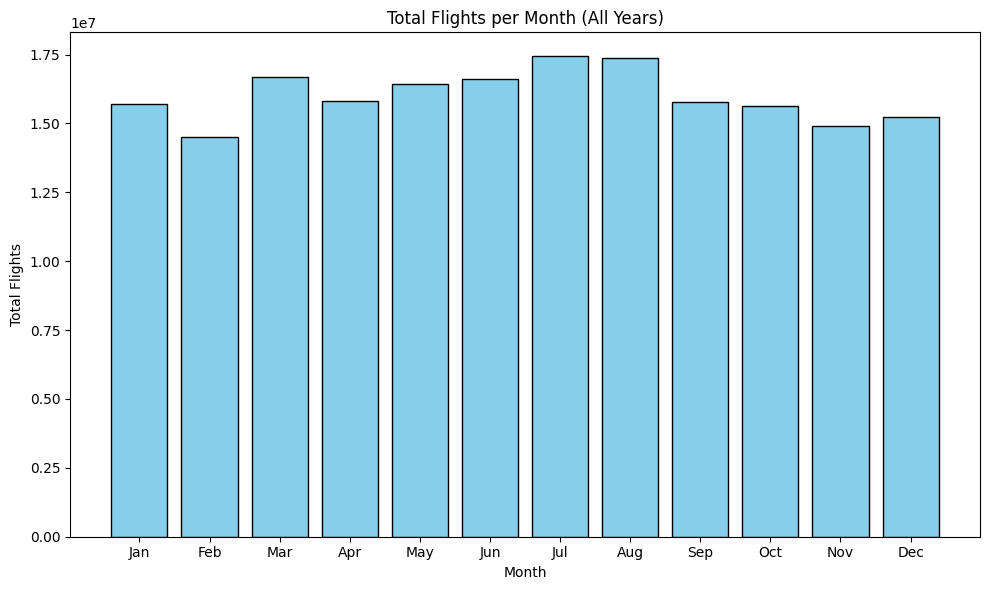

C:\Users\Errado\AppData\Local\Temp\ipykernel_14504\2293526212.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')


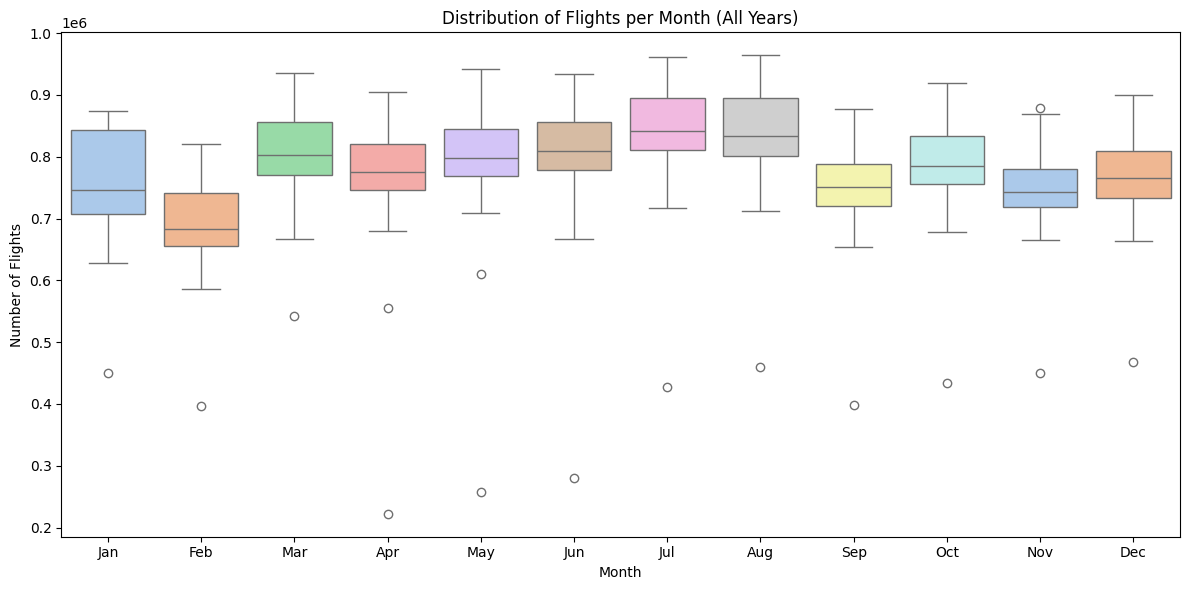

In [15]:
df_airline = pd.read_pickle(PATH + FILTERED_PATH + 'airline.pkl')

# Group by 'Month' and sum 'Flt'
monthly_flt_sum = df_airline.groupby('Month')['Flt'].sum().reset_index()

# Sort by month to be sure
monthly_flt_sum = monthly_flt_sum.sort_values('Month')

# Map month numbers to names (Jan, Feb, ...)
month_names = [calendar.month_abbr[m] for m in monthly_flt_sum['Month']]
monthly_flt_sum['Month_Name'] = month_names

# Display result
print(monthly_flt_sum)

# Histogram
# Plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_flt_sum['Month_Name'], monthly_flt_sum['Flt'], color='skyblue', edgecolor='black')

# Labels and title
plt.title('Total Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Total Flights')

plt.tight_layout()
plt.show()

# Box Plot
# Map numeric month to abbreviation
df_airline['Month_Name'] = df_airline['Month'].apply(lambda x: calendar.month_abbr[x])

# Optional: Order months correctly
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_airline, x='Month_Name', y='Flt', order=month_order, palette='pastel')

# Labels and title
plt.title('Distribution of Flights per Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

plt.tight_layout()
plt.show()

## A blocking strategy

In [16]:

# === 1. Data Loading ===
# Caricamento dei dataset
df_aircraft = pd.read_csv('data_sources/combined_aircraft_data.csv')
df_ntsb = pd.read_pickle(PATH + FILTERED_PATH + 'ntsb.pkl')

# Selezione delle colonne necessarie
df_ntsb_model = df_ntsb[['NtsbNumber', 'EventDate', 'Vehicles.SerialNumber',
                         'Vehicles.RegistrationNumber', 'Vehicles.Make', 'Vehicles.Model']].copy()

# === 2. Data Cleaning and Normalization ===
def clean_text(s):
    """ Normalizzazione del testo: rimozione di caratteri speciali, lowercase e spazi extra. """
    return re.sub(r'\W+', ' ', str(s)).lower().strip()

# Pulizia dei dati
df_ntsb_model['Vehicles.Model'] = df_ntsb_model['Vehicles.Model'].apply(clean_text)
df_ntsb_model['Vehicles.Make'] = df_ntsb_model['Vehicles.Make'].apply(clean_text)

df_aircraft['model_no'] = df_aircraft['model_no'].apply(clean_text)
df_aircraft['manufacturer_code'] = df_aircraft['manufacturer_code'].apply(clean_text)

df_ntsb_model.dropna(subset=['Vehicles.Model'], inplace=True)
df_aircraft.dropna(subset=['model_no'], inplace=True)

# === 3. Similarity Setup ===
jw = sm.JaroWinkler()
lev = sm.Levenshtein()
jac = sm.Jaccard()  

# === 4. Precomputation degli n-gram ===
def generate_qgrams(model):
    """ Genera un insieme di trigrammi (q-grams di lunghezza 3) per una stringa data. """
    qgrams = [model[i:i+3] for i in range(len(model) - 2)]
    return set(qgrams)

# === 5. Matching with Optimized Loop ===
matches = []
matched_set = set()  # Set per controllare i duplicati di NtsbNumber + SerialNumber
serial_set = set()   # Set per controllare i duplicati di SerialNumber

for i, ntsb_row in df_ntsb_model.iterrows():
    model_ntsb = ntsb_row['Vehicles.Model']
    make_ntsb = ntsb_row['Vehicles.Make']
    grams_ntsb = generate_qgrams(model_ntsb)

    # 🔎 **Filtro preliminare basato sul Make (flessibile)**
    filtered_aircraft = df_aircraft[
        df_aircraft['manufacturer_code'].apply(lambda x: make_ntsb in x or x in make_ntsb or jw.get_sim_score(x, make_ntsb) > 0.85)
    ]
    
    # Se non ci sono candidati, passa al prossimo ciclo
    if filtered_aircraft.empty:
        continue

    # Precomputa gli n-gram per i candidati
    aircraft_grams = {index: generate_qgrams(model) for index, model in enumerate(filtered_aircraft['model_no'])}

    # 🔎 **Filtro preliminare basato sugli n-grammi**
    candidate_matches = []
    for idx, grams_aircraft in aircraft_grams.items():
        if len(grams_ntsb & grams_aircraft) >= 2:
            candidate_matches.append(filtered_aircraft.index[idx])

    if not candidate_matches:
        continue  # Nessun match possibile, passo al successivo

    # 🔎 **Controllo diretto:** se esiste un match esatto tra i candidati
    direct_match = df_aircraft.loc[candidate_matches]
    direct_match = direct_match[direct_match['model_no'] == model_ntsb]

    if not direct_match.empty:
        for _, row in direct_match.iterrows():
            match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{row['model_no']}"
            if match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
                matches.append({
                    'NtsbNumber': ntsb_row['NtsbNumber'],
                    'EventDate': ntsb_row['EventDate'],
                    'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                    'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                    'Vehicles.Make': ntsb_row['Vehicles.Make'],
                    'Vehicles.Model': model_ntsb,
                    'Matched_Aircraft_Model': row['model_no'],
                    'engine_count': row['engine_count'],
                    'engine_type': row['engine_type'],
                    'JW_Score': 1.0,
                    'LEV_Score': 1.0,
                    'Jac_Score': 1.0,
                    'SimilarityScore': 1.0
                })
                matched_set.add(match_id)
                serial_set.add(ntsb_row['Vehicles.SerialNumber'])

        continue  # Salta il loop di matching

    # 🔎 **Controllo di Variante Generico**
    for idx in candidate_matches:
        model_aircraft = df_aircraft.loc[idx, 'model_no']

        # Numeric Filter: numbers must match if present
        nums_ntsb = re.findall(r'\d+', model_ntsb)
        nums_aircraft = re.findall(r'\d+', model_aircraft)

        if nums_ntsb and nums_aircraft and nums_ntsb != nums_aircraft:
            continue

        # Computing the Three Similarity Scores
        jw_score = jw.get_sim_score(model_ntsb, model_aircraft)
        lev_score = lev.get_sim_score(model_ntsb, model_aircraft)
        jac_score = jac.get_sim_score(list(grams_ntsb), list(generate_qgrams(model_aircraft)))

        # Linear Rule
        final_score = 0.4 * jw_score + 0.3 * lev_score + 0.3 * jac_score

        # Controllo duplicati
        match_id = f"{ntsb_row['NtsbNumber']}_{ntsb_row['Vehicles.SerialNumber']}_{model_aircraft}"
        if final_score > 0.75 and match_id not in matched_set and ntsb_row['Vehicles.SerialNumber'] not in serial_set:
            matches.append({
                'NtsbNumber': ntsb_row['NtsbNumber'],
                'EventDate': ntsb_row['EventDate'],
                'Vehicles.SerialNumber': ntsb_row['Vehicles.SerialNumber'],
                'Vehicles.RegistrationNumber': ntsb_row['Vehicles.RegistrationNumber'],
                'Vehicles.Make': ntsb_row['Vehicles.Make'],
                'Vehicles.Model': model_ntsb,
                'Matched_Aircraft_Model': model_aircraft,
                'engine_count': df_aircraft.loc[idx, 'engine_count'],
                'engine_type': df_aircraft.loc[idx, 'engine_type'],
                'JW_Score': round(jw_score, 3),
                'LEV_Score': round(lev_score, 3),
                'Jac_Score': round(jac_score, 3),
                'SimilarityScore': round(final_score, 4)
            })
            matched_set.add(match_id)
            serial_set.add(ntsb_row['Vehicles.SerialNumber'])

# === 6. Final Output ===
if not matches:
    print("No matches found with the current rules.")
else:
    df_matches = pd.DataFrame(matches)
    print(f"Matches Found: {len(df_matches)}")
    print("Columns:", df_matches.columns.tolist())
    df_matches = df_matches.sort_values(by='SimilarityScore', ascending=False)
    display(df_matches.head(25))


NameError: name 'sm' is not defined

#### All Match

In [ ]:
display(df_matches)

In [ ]:
df_matches.to_csv(PATH+"binding/matched_results.csv", index=False)

***Individual Challenge: Data Cleaning Expert***

*Manuel Cardoso 56274*

Duplicated dataset: NTSB

In [17]:
with open("data_sources/ntsb-us-2003-2023.json", 'r', encoding='utf-8') as f:
    ic_ntsb = json.load(f)

##### THE CODE ON THE START OF THE CELL BELOW IS COPIED FROM THE START OF THE PROJECT JUST TO HAVE AN EQUAL DATASET, THE INDIVIDUAL CHALLENGE WILL BE DONE WITH THE DATA THAT REMAINS

In [41]:
# Each record is one accident/incident entry in a list

# Convert to a DataFrame (this will flatten top-level fields)
# For nested fields like 'Vehicles', we might do a separate flatten later
messy_ntsb = pd.json_normalize(ic_ntsb, 
                            meta=[
                                'Oid','MKey','Closed','CompletionStatus','HasSafetyRec',
                                'HighestInjury','IsStudy','Mode','NtsbNumber',
                                'OriginalPublishedDate','MostRecentReportType','ProbableCause',
                                'City','Country','EventDate','State','Agency','BoardLaunch',
                                'BoardMeetingDate','DocketDate','EventType','Launch','ReportDate',
                                'ReportNum','ReportType','AirportId','AirportName','AnalysisNarrative',
                                'FactualNarrative','PrelimNarrative','FatalInjuryCount','MinorInjuryCount',
                                'SeriousInjuryCount','InvestigationClass','AccidentSiteCondition',
                                'Latitude','Longitude','DocketOriginalPublishDate'
                            ],
                            record_path=['Vehicles'],  # This flattens out the 'Vehicles' array
                            record_prefix='Vehicles.'
                           )

# combines all injury counts to 1 column
messy_ntsb['TotalInjuryCount'] = messy_ntsb[['FatalInjuryCount', 'MinorInjuryCount', 'SeriousInjuryCount']].sum(axis=1)

# dropping unnecessary columns
messy_ntsb.drop(columns=['AnalysisNarrative','FactualNarrative','PrelimNarrative','InvestigationClass','BoardLaunch'
                      ,'BoardMeetingDate','Launch','IsStudy','OriginalPublishedDate','DocketOriginalPublishDate'
                      ,'ReportType','ReportNum','ReportDate','MostRecentReportType','FatalInjuryCount','MinorInjuryCount'
                      ,'SeriousInjuryCount','DocketDate','Mode','HasSafetyRec','CompletionStatus','Closed'
                      ,'Vehicles.AircraftCategory','Vehicles.AmateurBuilt','Vehicles.EventID','Vehicles.AirMedical'
                      ,'Vehicles.AirMedicalType','Vehicles.flightScheduledType','Vehicles.flightServiceType'
                      ,'Vehicles.flightTerminalType','Vehicles.RegisteredOwner','Vehicles.RegulationFlightConductedUnder'
                      ,'Vehicles.RepGenFlag','Vehicles.RevenueSightseeing','Vehicles.SecondPilotPresent','Vehicles.Damage'
                      ,'AccidentSiteCondition'], inplace=True) 

# dropping NaT entries from EventDate
messy_ntsb = messy_ntsb.dropna(subset=['EventDate'])

# Type Conversion
messy_ntsb['EventDate'] = pd.to_datetime(messy_ntsb['EventDate']).dt.tz_localize(None)
messy_ntsb['Vehicles.VehicleNumber'] = pd.to_numeric(messy_ntsb['Vehicles.VehicleNumber'], errors='coerce').astype(int)
messy_ntsb['MKey'] = pd.to_numeric(messy_ntsb['MKey'], errors='coerce').astype(int)
messy_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(messy_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(float) # only change from the original Data Cleaning so it was easier to manipulate
messy_ntsb['Latitude'] = pd.to_numeric(messy_ntsb['Latitude'], errors='coerce').astype(float)
messy_ntsb['Longitude'] = pd.to_numeric(messy_ntsb['Longitude'], errors='coerce').astype(float)
messy_ntsb['TotalInjuryCount'] = pd.to_numeric(messy_ntsb['TotalInjuryCount'], errors='coerce').astype(int)

categorical_cols = [
    'Vehicles.DamageLevel',
    'Vehicles.ExplosionType',
    'Vehicles.FireType',
    'HighestInjury',
    'EventType',
    'AccidentSiteCondition'
]

for col in categorical_cols:
    if col in messy_ntsb.columns:
        messy_ntsb[col] = messy_ntsb[col].astype('category')

messy_ntsb = messy_ntsb.map(lambda x: x.lower() if isinstance(x, str) else x) # make all appropriate values lowercase

#################################################################################### CODE ABOVE IS COPIED ####################################################################################

starting_entries = len(messy_ntsb)
print(f"Number of starting entries: {starting_entries}")

# Manipulating records
seed = 5 # for reproducibility

# Introducing missing values on Vehicles.Make column
missing_count = messy_ntsb['Vehicles.Make'].isna().sum()
print(missing_count)
np.random.seed(seed) 
n = starting_entries
n_missing = int(np.floor(0.1 * n)) # 0.1 = 10% missing values
missing_indices = np.random.choice(messy_ntsb.index, n_missing, replace=False)
messy_ntsb.loc[missing_indices, "Vehicles.Make"] = np.nan
print(f"Number of entries after introducing missing values: {len(messy_ntsb)}")

# Introducing duplicate records
n_dup = int(np.floor(0.05 * n)) # 0.05 = 5% duplicated records
# Randomly choose rows to duplicate
dup_indices = np.random.choice(messy_ntsb.index, n_dup, replace=False)
duplicates = messy_ntsb.loc[dup_indices].copy()
# Append duplicates to original DataFrame
messy_ntsb = pd.concat([messy_ntsb, duplicates], ignore_index=True)
print(f"Number of entries after introducing duplicate records: {len(messy_ntsb)}")
n = len(messy_ntsb) # reset

# Introducing negative and incorrect values for Vehicles.NumberOfEngines
n_invalid = int(np.floor(0.05 * n)) # 0.05 = 5% induced negatives and incorrect 
# Randomly choose rows
invalid_indices = np.random.choice(messy_ntsb.index, n_invalid, replace=False)
# Flip values to negative (ensure they're numeric first)
messy_ntsb.loc[invalid_indices, "Vehicles.NumberOfEngines"] = -messy_ntsb.loc[invalid_indices, "Vehicles.NumberOfEngines"].abs()
# Randomly choose rows
invalid_indices = np.random.choice(messy_ntsb.index, n_invalid, replace=False)
# Flip values to negative (ensure they're numeric first)
messy_ntsb.loc[invalid_indices, "Vehicles.NumberOfEngines"] = (messy_ntsb.loc[invalid_indices, "Vehicles.NumberOfEngines"] + (0.01*np.random.rand())) # add decimals to the Number of Engines
print(f"Number of entries after introducing invalid values: {len(messy_ntsb)}")

# Introducing Outliers in 'Longitude' and 'Latitude' columns
n_outliers = int(np.floor(0.025 * n)) # 0.025 = 2.5% induced outliers
# Longitude: valid range ~ -180 to 180
outlier_indices = np.random.choice(messy_ntsb.index, n_outliers, replace=False)
messy_ntsb.loc[outlier_indices, 'Longitude'] = (messy_ntsb.loc[outlier_indices, 'Longitude'] + np.random.uniform(400, 500, size=n_outliers)) # clearly invalid, just to induce
# Latitude: valid range ~ -90 to 90
outlier_indices = np.random.choice(messy_ntsb.index, n_outliers, replace=False)
messy_ntsb.loc[outlier_indices, 'Latitude'] = (messy_ntsb.loc[outlier_indices, 'Latitude'] + np.random.uniform(200, 300, size=n_outliers)) # clearly invalid, just to induce
print(f"Number of entries after introducing outliers in 'Longitude' and 'Latitude': {len(messy_ntsb)}")

messy_ntsb

Number of starting entries: 23403
1
Number of entries after introducing missing values: 23403
Number of entries after introducing duplicate records: 24573
Number of entries after introducing invalid values: 24573
Number of entries after introducing outliers in 'Longitude' and 'Latitude': 24573


,Vehicles.VehicleNumber,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,...,Country,EventDate,State,Agency,EventType,AirportId,AirportName,Latitude,Longitude,TotalInjuryCount
0,1,substantial,none,none,0702,cirrus design corp,sr22t,1.0,n773gb,pers,...,usa,2023-12-31 17:40:00,ia,ntsb,acc,dvn,None,41.610278,-90.588361,0
1,1,substantial,none,none,004ce,golden avio s r l,f30 brio,-1.0,n37ga,pers,...,usa,2023-12-31 16:13:00,va,ntsb,acc,hwy,warrenton/fauquier,38.586285,-77.710631,0
2,1,substantial,none,none,4692139,piper aircraft inc,pa46r-350t,1.0,n539ma,pers,...,usa,2023-12-31 14:13:00,nc,ntsb,acc,14a,lake norman airpark,35.624637,-80.912255,1
3,1,substantial,none,none,79-30941,bellanca,17-30a,1.0,n678mj,pers,...,usa,2023-12-30 17:00:00,mo,ntsb,acc,fyg,washington regional,38.587583,-90.993806,1
4,1,substantial,none,none,7452c,maule,m-6-235,1.0,n71ms,aobv,...,usa,2023-12-29 16:27:00,tx,ntsb,acc,bpt,jack brooks rgnl,30.070603,-94.215837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24568,1,substantial,NaN,none,24-0480,mooney,m20j,1.0,n201le,pers,...,usa,2007-08-08 20:30:00,mo,None,acc,sus,spirit of st louis airport,38.661945,-90.653335,0
24569,1,substantial,none,none,17258976,cessna,172k,1.0,n7276g,pers,...,usa,2011-10-30 16:20:00,mt,ntsb,acc,6s5,ravalli county,46.611667,-114.046669,0
24570,1,substantial,none,none,22393,cessna,305a,1.0,n1831,pers,...,usa,2019-07-21 10:20:00,mo,ntsb,acc,m48,houston memorial airport,37.333332,-91.966667,0
24571,1,substantial,none,none,15064656,cessna,150g,1.0,n4606x,inst,...,usa,2005-06-01 11:00:00,ct,ntsb,acc,ijd,windham,41.743888,-72.180000,0


### Data Cleaning
#### For this challenge, I'm going to assume that the user noticed the errors on the specific columns and dealt with them (Qualitative Cleaning - "Manual crafting of rules and transform function")

In [42]:
# This block of code needs the previous block of code to be ran first
cleaning_messy_ntsb = messy_ntsb.copy()
# First, start by dropping duplicate rows (this will have to be done again at the end, we do it at the start anyway to minimize computing needs)
cleaning_messy_ntsb = cleaning_messy_ntsb.drop_duplicates()
print(f"Number of entries after dropping duplicates: {len(cleaning_messy_ntsb)}")

print("----------")

# Fixing missing values in column Vehicles.Make
# Filter rows where 'Vehicles.Make' is not missing
model_dict = {}
missing_count = cleaning_messy_ntsb['Vehicles.Make'].isna().sum()
print(f"Number of NaN: {missing_count}")
for index, row in cleaning_messy_ntsb.iterrows():
    make = row['Vehicles.Make']
    model = row['Vehicles.Model']
    
    if pd.notna(make):  # Only build dict from known makes
        model_dict[model] = make

# Iterate again to replace NaNs
for index, row in cleaning_messy_ntsb.iterrows():
    make = row['Vehicles.Make']
    model = row['Vehicles.Model']
    
    if pd.isna(make):  # Only build dict from known makes
        cleaning_messy_ntsb.loc[index, 'Vehicles.Make'] = model_dict.get(model, None)


print(f"Number of entries after fixing Vehicles.Make: {len(cleaning_messy_ntsb)}")

missing_count = cleaning_messy_ntsb['Vehicles.Make'].isna().sum()
print(f"Number of NaN after trying to fix Vehicles.Make: {missing_count}") 
# We can check that not all was fixed, I tried to fix by checking with other entries that had the same Model
# but if a Model never has a Make to begin with, this can't be done

print("----------")

# Fixing invalid values in Vehicles.NumberOfEngines
engines_dict = {}
negative_count = (cleaning_messy_ntsb['Vehicles.NumberOfEngines'] < 0).sum()
decimal_count = (cleaning_messy_ntsb['Vehicles.NumberOfEngines'] % 1 != 0).sum() - cleaning_messy_ntsb['Vehicles.NumberOfEngines'].isna().sum() # NaNs count here if not for the subtraction
print(f"Number of negatives: {negative_count}")
print(f"Number of numbers with decimal parts: {decimal_count}")
for index, row in cleaning_messy_ntsb.iterrows():
    engines = row['Vehicles.NumberOfEngines']
    model = row['Vehicles.Model']

    if engines.is_integer() and engines >= 1:
        engines_dict[model] = engines

    elif engines < 0:
        cleaning_messy_ntsb.loc[index, 'Vehicles.NumberOfEngines'] = abs(engines)

# Iterate again to check for the ones with decimal parts and previously negative
for index, row in cleaning_messy_ntsb.iterrows():
    model = row['Vehicles.Model']

    if model in engines_dict:
        cleaning_messy_ntsb.loc[index, 'Vehicles.NumberOfEngines'] = engines_dict[model]
    else:
        cleaning_messy_ntsb.loc[index, 'Vehicles.NumberOfEngines'] = None # I could round the number to the closet whole number but that wouldn't be trustworthy 
                                                                 # so I think it's better to replace it with None


negative_count = (cleaning_messy_ntsb['Vehicles.NumberOfEngines'] < 0).sum()
decimal_count = (cleaning_messy_ntsb['Vehicles.NumberOfEngines'] % 1 != 0).sum() - cleaning_messy_ntsb['Vehicles.NumberOfEngines'].isna().sum()
print(f"Number of negatives after trying to fix Vehicles.NumberOfEngines: {negative_count}")
print(f"Number of numbers with decimal parts after trying to fix Vehicles.NumberOfEngines: {decimal_count}")

cleaning_messy_ntsb['Vehicles.NumberOfEngines'] = pd.to_numeric(cleaning_messy_ntsb['Vehicles.NumberOfEngines'], errors='coerce').fillna(0).astype(int) # fix Type Conversion

print("----------")

# Removing outliers from Longitude and Latitude ~ -180 to 180
longitude_count = (cleaning_messy_ntsb['Longitude'] < -180).sum() + (cleaning_messy_ntsb['Longitude'] > 180).sum()
latitude_count = (cleaning_messy_ntsb['Latitude'] < -90).sum() + (cleaning_messy_ntsb['Latitude'] > 90).sum()
print(f"Number of outliers in Longitude: {longitude_count}")
print(f"Number of outliers in Latitude: {latitude_count}")
for index, row in cleaning_messy_ntsb.iterrows():
    long = row['Longitude']
    lat = row['Latitude']

    if long and (long < -180 or long > 190):
        cleaning_messy_ntsb.loc[index, 'Longitude'] = None

    if lat and (lat < -90 or lat > 90):
        cleaning_messy_ntsb.loc[index, 'Latitude'] = None

longitude_count = (cleaning_messy_ntsb['Longitude'] < -180).sum() + (cleaning_messy_ntsb['Longitude'] > 180).sum()
latitude_count = (cleaning_messy_ntsb['Latitude'] < -90).sum() + (cleaning_messy_ntsb['Latitude'] > 90).sum()
print(f"Number of outliers in Longitude after fix: {longitude_count}")
print(f"Number of outliers in Latitude after fix: {latitude_count}")

print("----------")

cleaning_messy_ntsb = cleaning_messy_ntsb.drop_duplicates()
print(f"Number of entries after dropping duplicates at the end: {len(cleaning_messy_ntsb)}") # we do this again because there may exist rows that had records manipulated and weren't 
                                                                                    # duplicated because of that, but at the end of the Data Cleaning could be duplicated again
print(f"Number of starting entries for comparison: {starting_entries}") # this value being different is natural, as the order of the manipulation has the duplication happening before other
                                                                        # data issue insertions,, I tested with the duplication as the last manipulation and the number of entries
                                                                        # at the end of the Data Cleaning coincides with the starting entries (23403)

cleaning_messy_ntsb

Number of entries after dropping duplicates: 23700
----------
Number of NaN: 2365
Number of entries after fixing Vehicles.Make: 23700
Number of NaN after trying to fix Vehicles.Make: 154
----------
Number of negatives: 1198
Number of numbers with decimal parts: 1226
Number of negatives after trying to fix Vehicles.NumberOfEngines: 0
Number of numbers with decimal parts after trying to fix Vehicles.NumberOfEngines: 0
----------
Number of outliers in Longitude: 613
Number of outliers in Latitude: 608
Number of outliers in Longitude after fix: 0
Number of outliers in Latitude after fix: 0
----------
Number of entries after dropping duplicates at the end: 23522
Number of starting entries for comparison: 23403


,Vehicles.VehicleNumber,Vehicles.DamageLevel,Vehicles.ExplosionType,Vehicles.FireType,Vehicles.SerialNumber,Vehicles.Make,Vehicles.Model,Vehicles.NumberOfEngines,Vehicles.RegistrationNumber,Vehicles.FlightOperationType,...,Country,EventDate,State,Agency,EventType,AirportId,AirportName,Latitude,Longitude,TotalInjuryCount
0,1,substantial,none,none,0702,cirrus design corp,sr22t,1,n773gb,pers,...,usa,2023-12-31 17:40:00,ia,ntsb,acc,dvn,None,41.610278,-90.588361,0
1,1,substantial,none,none,004ce,golden avio s r l,f30 brio,0,n37ga,pers,...,usa,2023-12-31 16:13:00,va,ntsb,acc,hwy,warrenton/fauquier,38.586285,-77.710631,0
2,1,substantial,none,none,4692139,piper aircraft inc,pa46r-350t,1,n539ma,pers,...,usa,2023-12-31 14:13:00,nc,ntsb,acc,14a,lake norman airpark,35.624637,-80.912255,1
3,1,substantial,none,none,79-30941,bellanca,17-30a,1,n678mj,pers,...,usa,2023-12-30 17:00:00,mo,ntsb,acc,fyg,washington regional,38.587583,-90.993806,1
4,1,substantial,none,none,7452c,maule,m-6-235,1,n71ms,aobv,...,usa,2023-12-29 16:27:00,tx,ntsb,acc,bpt,jack brooks rgnl,30.070603,-94.215837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24537,1,minor,none,none,30280,boeing,737,2,n551wn,None,...,usa,2008-10-01 10:55:00,il,ntsb,inc,mdw,chicago midway,41.889202,NaN,0
24541,1,substantial,none,none,1993p,flightstar sportplanes,flightstar ii,1,n194pg,pers,...,usa,2011-05-22 19:45:00,ga,ntsb,acc,cco,newnan-coweta,33.258609,-84.844444,0
24553,1,substantial,none,none,21062182,cessna,210,1,n761dv,aobv,...,usa,2018-03-16 15:45:00,vt,ntsb,acc,None,None,44.380554,-73.227500,0
24561,1,substantial,none,none,17263883,cessna,172m,1,n20965,inst,...,usa,2006-08-03 08:30:00,ga,ntsb,acc,kags,augusta regional-bush field,33.369720,NaN,0
